# Dataset preprocessing and model building

## Importing necessary libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import itertools
import cv2
import requests

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Importing dataset 

In [2]:
#Defining a function to import sample images from directory
def import_image_to_array(directory_path, size):
    # Define empty lists to store the images array and their respective labels
    image_arrays = []
    
    directory = os.listdir(directory_path)

    for image_name in directory:
        
        #Load an image from the specified directory
        image = cv2.imread(directory_path + image_name)
            
        #Resize image to the specified size
        image = cv2.resize(image, size)

        #Update the image dataset and labels lists respectively
        image_arrays.append(image)
            
    return image_arrays

In [3]:
#Defining directories and calling above function
NORMAL_DIR = "/Users/casarulez/Projects/Covid-19/COVID_IEEE/normal/"  # Normal CXR Image Dataset
VIRAL_DIR = "/Users/casarulez/Projects/Covid-19/COVID_IEEE/virus/"    # Viral Pneumonia CXR Image Dataset
COVID_DIR = "/Users/casarulez/Projects/Covid-19/COVID_IEEE/covid/"    # COVID-19 CXR Image Dataset

normal_dataset = import_image_to_array(NORMAL_DIR, (224,224))
viral_dataset = import_image_to_array(VIRAL_DIR, (224,224))
covid_dataset = import_image_to_array(COVID_DIR, (224,224))

In [4]:
#Printing dataset organization
print("Dataset architecture:")
print("Normal X-ray images:",len(normal_dataset))
print("Viral X-ray images:",len(viral_dataset))
print("Covid X-ray images:",len(covid_dataset))

Dataset architecture:
Normal X-ray images: 668
Viral X-ray images: 619
Covid X-ray images: 536


## Previewing few images 

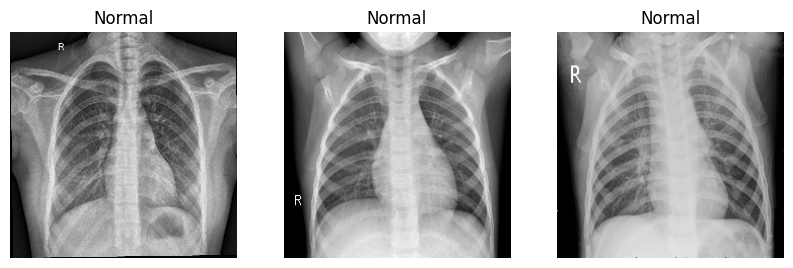

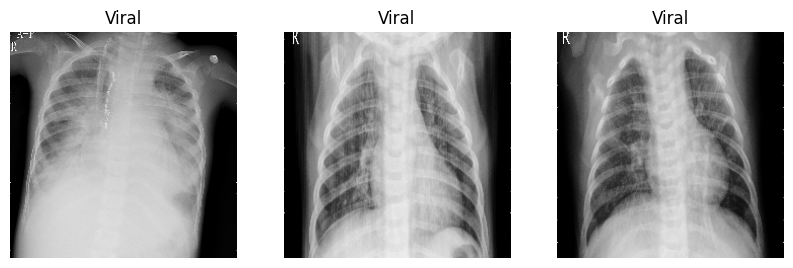

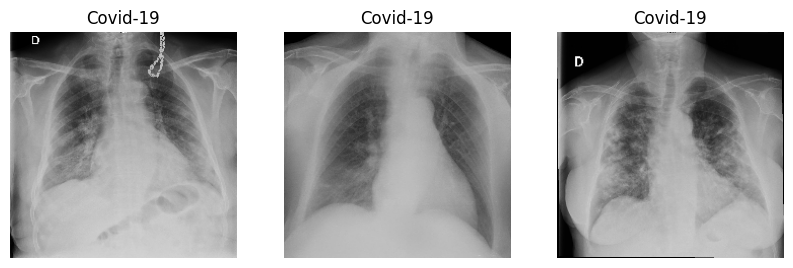

In [5]:
#Plotting normal X-rays
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(normal_dataset[images], cmap = "gray")
    plt.title("Normal")
    plt.axis("off")
    
# Viral X-rays
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(viral_dataset[images], cmap = "gray")
    plt.title("Viral")
    plt.axis("off")
    
# COVID-19 X-rays
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(covid_dataset[images], cmap = "gray")
    plt.title("Covid-19")
    plt.axis("off")

## Image processing 

In [6]:
#Function to perform white balancing on images
def white_balance(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [7]:
#Function to perform CLAHE on images
def clahe():
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    return clahe

In [8]:
#Function to enhance images using CLAHE and white balancing.
def image_enhancer(image_arrays):
    enhanced_images = []
    
    for image in image_arrays:
        
        #White Balance
        image_WB  = np.dstack([white_balance(channel, 0.05) for channel in cv2.split(image)] )
        gray_image = cv2.cvtColor(image_WB, cv2.COLOR_RGB2GRAY)

        #CLAHE
        clahe_function = clahe()
        image_clahe = clahe_function.apply(gray_image)
        image = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        
        enhanced_images.append(image)
    
    return enhanced_images

In [9]:
normal_dataset_enhanced = image_enhancer(normal_dataset) 
viral_dataset_enhanced = image_enhancer(viral_dataset)
covid_dataset_enhanced = image_enhancer(covid_dataset)

## Comparing non enhanced vs enhanced images 

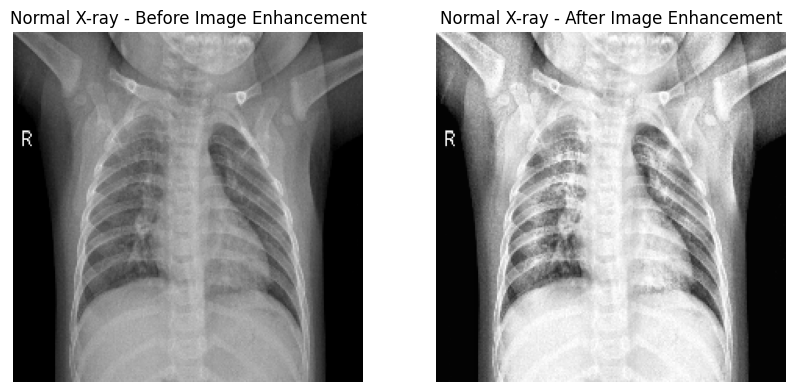

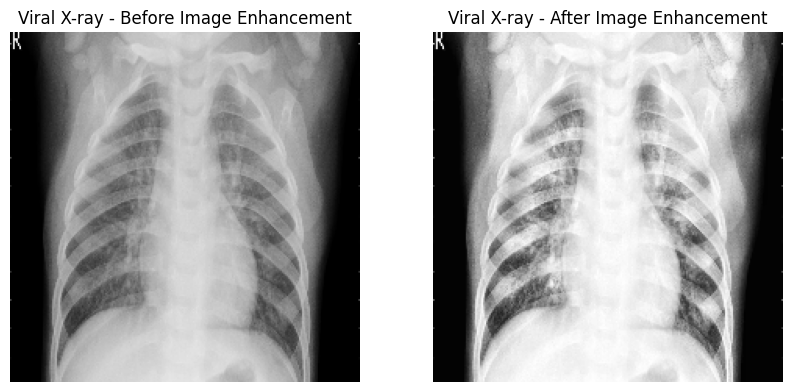

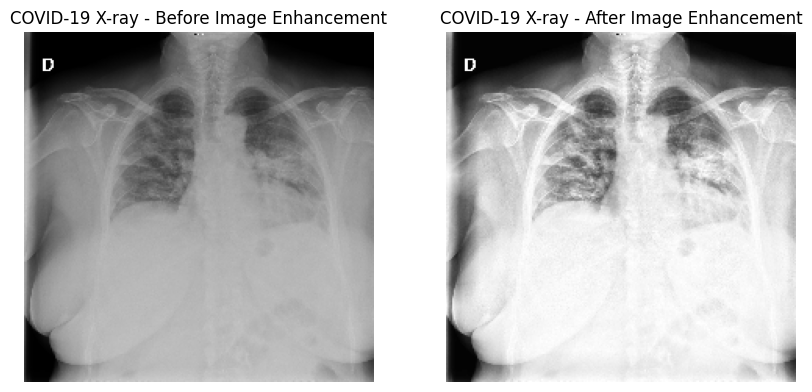

In [10]:
#Normal X-ray
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(normal_dataset[100], cmap = "gray")
plt.title("Normal X-ray - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(normal_dataset_enhanced[100], cmap = "gray")
plt.title("Normal X-ray - After Image Enhancement")
plt.axis("off")
    
#Viral X-ray
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(viral_dataset[100], cmap = "gray")
plt.title("Viral X-ray - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(viral_dataset_enhanced[100], cmap = "gray")
plt.title("Viral X-ray - After Image Enhancement")
plt.axis("off")
    
#Covid-19 X-ray
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(covid_dataset[100], cmap = "gray")
plt.title("COVID-19 X-ray - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(covid_dataset_enhanced[100], cmap = "gray")
plt.title("COVID-19 X-ray - After Image Enhancement")
plt.axis("off")

plt.show()

## Normalizing dataset 

In [11]:
#Function to normalize dataset
def normalizer(image_arrays):
    # Create an empty list to store normalized arrays
    norm_image_arrays = []
    
    # Iterate over all the image arrays and normalize them before storing them into our predefined list
    for image_array in image_arrays:
        norm_image_array = image_array / 255.0
        norm_image_arrays.append(norm_image_array)
    
    return norm_image_arrays

In [12]:
normal_dataset_normalized = normalizer(normal_dataset_enhanced)
viral_dataset_normalized = normalizer(viral_dataset_enhanced)
covid_dataset_normalized = normalizer(covid_dataset_enhanced)

## Train-test-validation split 

In [13]:
#Printing shapes of classes for reference
print("Normal:",len(normal_dataset_normalized))
print("Viral:",len(viral_dataset_normalized))
print("Covid:",len(covid_dataset_normalized))

Normal: 668
Viral: 619
Covid: 536


In [14]:
#Combine the three classes into a single dataset
combined_dataset = np.concatenate((normal_dataset_normalized, viral_dataset_normalized, covid_dataset_normalized), axis=0)

#Generate labels for the three classes
normal_labels = np.zeros(len(normal_dataset_normalized))  # Label 0 for normal
viral_labels = np.ones(len(viral_dataset_normalized))      # Label 1 for viral
covid_labels = 2 * np.ones(len(covid_dataset_normalized))  # Label 2 for COVID

#Combine the labels into a single array
combined_labels = np.concatenate((normal_labels, viral_labels, covid_labels), axis=0)

#One hot encoding the labels
combined_labels = to_categorical(combined_labels, num_classes=3)

#Split the combined dataset and labels into training, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(combined_dataset, combined_labels, test_size=0.3, random_state=42)
validation_data, test_data, validation_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)


In [15]:
#Printing shapes of split data
print("Shape of training data:",train_data.shape)
print("Shape of testing data:",test_data.shape)
print("Shape of validation data:",validation_data.shape)

Shape of training data: (1276, 224, 224, 3)
Shape of testing data: (274, 224, 224, 3)
Shape of validation data: (273, 224, 224, 3)


In [16]:
#Printing shapes of labels
print("Shape of training labels:",train_labels.shape)
print("Shape of testing labels:",test_labels.shape)
print("Shape of validation labels:",validation_labels.shape)

Shape of training labels: (1276, 3)
Shape of testing labels: (274, 3)
Shape of validation labels: (273, 3)


## Performing data augmentation 

In [17]:
#Defining function to perform data augmentation

def data_augmenter():
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    
    return data_augmentation

2023-10-28 11:12:57.747563: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


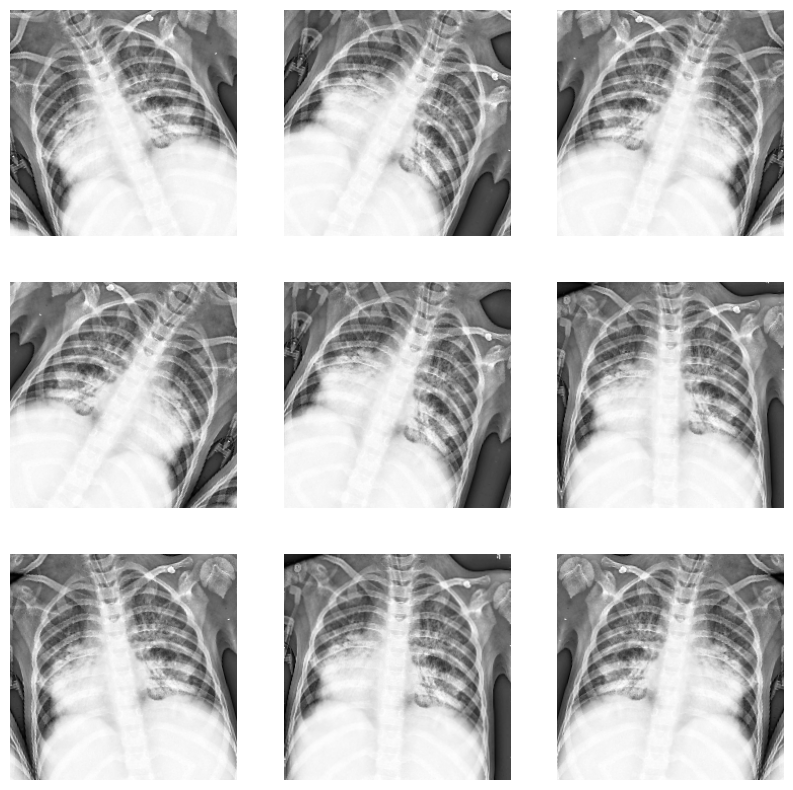

In [18]:
#Applying augmentation on an image
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
first_image = train_data[6]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    exp = tf.expand_dims(first_image, 0)
    augmented_image = data_augmentation(exp)
    plt.imshow(augmented_image[0])
    plt.axis('off')

## Applying transfer learning use MobileNetV2 as source model 

In [19]:
def make_mobilenet_model(image_size, num_classes, data_augmentation = data_augmenter()):
    
    input_shape = image_size + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    #Freeze the base model by making it non trainable
    base_model.trainable = False 

    #Create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    #Apply data augmentation to the inputs
    x = data_augmentation(inputs)
     
    #Set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    #Add the new Binary classification layers
    #use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)
        
    #Create a prediction layer
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    
    prediction_layer = Dense(units, activation=activation)
    
    outputs = prediction_layer(x)
    
    model = Model(inputs, outputs)
    
    return model

In [20]:
#Define a model using the make_model function
image_size = (224,224)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 3)

#Preview the Model Summary
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

## Defining model parameters and fitting

In [21]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)

In [22]:
mobilenet_history_freeze = mobilenet_model.fit(train_data, train_labels,
                                               batch_size = batch_size, 
                                               epochs = initial_epochs, 
                                               validation_data = (validation_data, validation_labels), 
                                               callbacks = [callback, reduce_lr], 
                                               shuffle = True)

Epoch 1/50
20/20 [==============================] - 11s 444ms/step - loss: 1.3135 - accuracy: 0.4616 - val_loss: 0.6299 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 8s 386ms/step - loss: 0.7708 - accuracy: 0.6528 - val_loss: 0.4355 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 8s 400ms/step - loss: 0.5714 - accuracy: 0.7719 - val_loss: 0.3850 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 8s 381ms/step - loss: 0.4888 - accuracy: 0.7970 - val_loss: 0.3405 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 7s 374ms/step - loss: 0.4249 - accuracy: 0.8378 - val_loss: 0.3210 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 7s 364ms/step - loss: 0.3941 - accuracy: 0.8354 - val_loss: 0.3086 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 8s 385ms/step - l

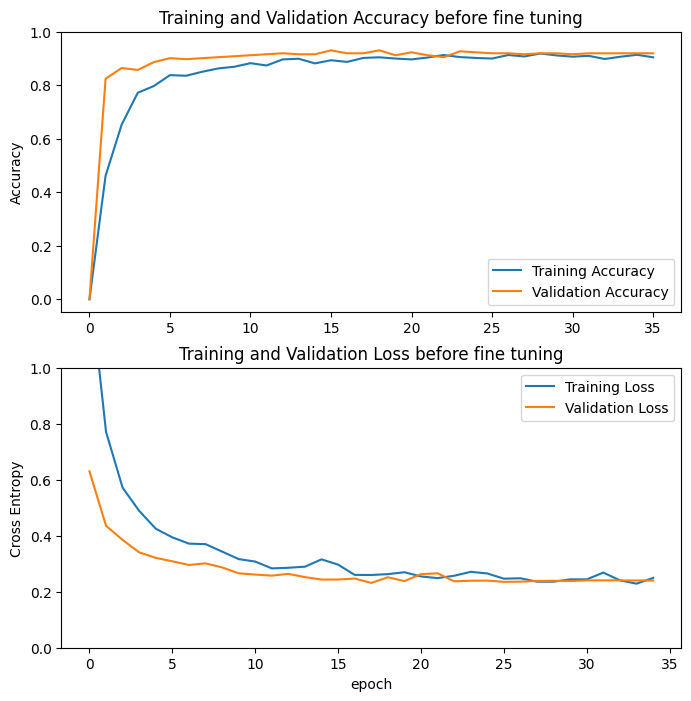

In [23]:
acc = [0.] + mobilenet_history_freeze.history['accuracy']
val_acc = [0.] + mobilenet_history_freeze.history['val_accuracy']

loss = mobilenet_history_freeze.history['loss']
val_loss = mobilenet_history_freeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy before fine tuning')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss before fine tuning')
plt.xlabel('epoch')
plt.show()

## Fine tuning 

In [24]:
base_mobilenet_model = mobilenet_model.layers[2] #MobileNetV2 Architecture
base_mobilenet_model.trainable = True

#The MobileNet Model has 155 layers (the prediction layer inclusive)
#Fine-tune from this layer onwards
fine_tune_at = 120

#Freeze all the layers before the `fine_tune_at` layer
for layer in base_mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = True


optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
                        loss = loss,
                        metrics = metrics)

In [25]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(train_data, train_labels,
                                             epochs = total_epochs,
                                             batch_size = batch_size,
                                             initial_epoch = mobilenet_history_freeze.epoch[-1],
                                             callbacks = [callback, reduce_lr], 
                                             validation_data = (validation_data, validation_labels),
                                             shuffle = True)

Epoch 35/80
20/20 [==============================] - 38s 2s/step - loss: 0.9825 - accuracy: 0.6207 - val_loss: 0.4697 - val_accuracy: 0.8498 - lr: 1.0000e-04
Epoch 36/80
20/20 [==============================] - 30s 1s/step - loss: 0.3996 - accuracy: 0.8605 - val_loss: 0.2223 - val_accuracy: 0.9158 - lr: 1.0000e-04
Epoch 37/80
20/20 [==============================] - 28s 1s/step - loss: 0.2934 - accuracy: 0.8934 - val_loss: 0.1542 - val_accuracy: 0.9414 - lr: 1.0000e-04
Epoch 38/80
20/20 [==============================] - 26s 1s/step - loss: 0.1932 - accuracy: 0.9310 - val_loss: 0.1490 - val_accuracy: 0.9451 - lr: 1.0000e-04
Epoch 39/80
20/20 [==============================] - 25s 1s/step - loss: 0.1981 - accuracy: 0.9326 - val_loss: 0.1825 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 40/80
20/20 [==============================] - 26s 1s/step - loss: 0.1570 - accuracy: 0.9350 - val_loss: 0.1866 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 41/80
20/20 [==============================] -

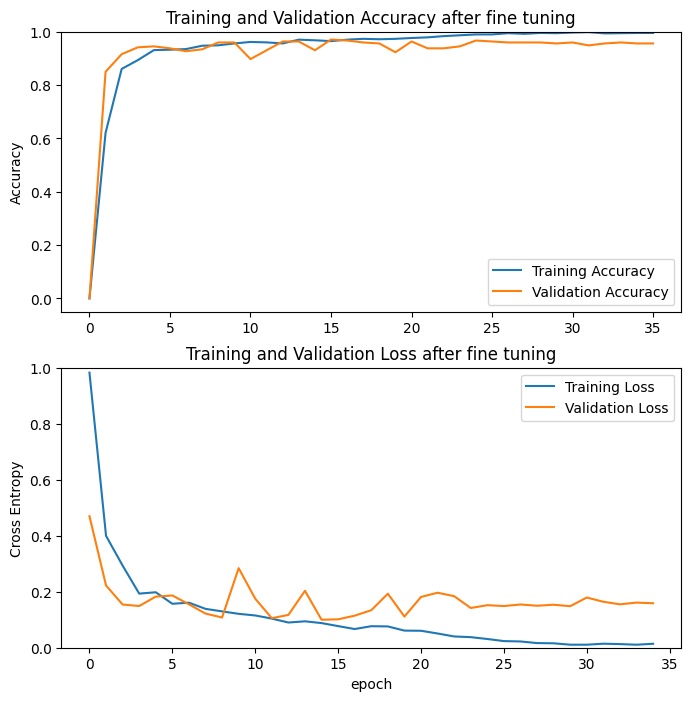

In [26]:
acc = [0.] + mobilenet_history_fine.history['accuracy']
val_acc = [0.] + mobilenet_history_fine.history['val_accuracy']

loss = mobilenet_history_fine.history['loss']
val_loss = mobilenet_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy after fine tuning')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss after fine tuning')
plt.xlabel('epoch')
plt.show()

## Saving model 

In [27]:
mobilenet_model.save('model_tuned.h5')

## Loading model 

In [28]:
mobilenet_model = load_model('model_tuned.h5')

## Classification report on test data 

In [29]:
test_predictions = mobilenet_model.predict(test_data, batch_size = 64)

test_predictions_classes = np.argmax(test_predictions, axis=1)
test_labels_classes = np.argmax(test_labels, axis=1) # Position of the actual label
    
print(classification_report(test_labels_classes, test_predictions_classes, target_names=['normal','covid','virus']))

5/5 [==============================] - 2s 226ms/step
              precision    recall  f1-score   support

      normal       0.94      0.95      0.94       107
       covid       0.94      0.95      0.95        86
       virus       1.00      0.96      0.98        81

    accuracy                           0.96       274
   macro avg       0.96      0.96      0.96       274
weighted avg       0.96      0.96      0.96       274



## Random value prediction 

In [30]:
def upload(directory,size):
    image_array=[]
    image = cv2.imread(directory)
    image = cv2.resize(image, size)
    image_array.append(image)    
    image_enhanced=image_enhancer(image_array)
    image_normalized=normalizer(image_enhanced)
    image_np=np.array(image_normalized)
    class_names = {0: "Normal", 1 : "Viral Pneumonia", 2: "COVID-19"}
    predictions = mobilenet_model.predict(image_np)
    predicted_labels = np.argmax(predictions, axis=1)
    print(class_names[predicted_labels[0]])   

In [31]:
upload("/Users/casarulez/Downloads/test/image.png",(224,224))

1/1 [==============================] - 0s 28ms/step
Viral Pneumonia
